In [8]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?
- These are websites that always relevant like recipies or reviews (as opposed to current events)
- Look at some examples

In [9]:
data = pd.read_csv('../../assets/datasets/train.tsv', sep='\t', na_values='?')

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', '')).fillna('')
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', '')).fillna('')

In [10]:
data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


#### In previous lessons, we added text features manually as below 

In [11]:
data['recipe'] = data['title'].str.lower().str.contains('recipe')
data['electronic'] = data['title'].str.lower().str.contains('electronic')
data['tips'] = data['title'].str.lower().str.contains('tips')

#### We can build a Logistic Regression model using scikit-learn and examine the coefficients
- Examine the coefficients using the `examine_coefficients` function provided

In [12]:
def examine_coefficients(model, df):
    df = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')
    return df[df.Coefficient !=0 ]

In [13]:
from sklearn.linear_model import LogisticRegression

X = data[[
        'recipe',
        'electronic',
        'tips'
    ]]
y = data.label


model = LogisticRegression() 

model.fit(X, y) # This fits the model to learn the coefficients
examine_coefficients(model, X)

,Coefficient,Feature
1,-0.441721,electronic
2,0.620250,tips
0,2.482849,recipe


#### We can build text features in bulk as well using built-in preprocessing tools
- `CountVectorizer` builds a feature per word automatically as we did manually for `recipe`, `electronic` above.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=50, # Only use the top 50 most common words
)


# This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
X = v.fit_transform(data.title).todense()
X = pd.DataFrame(X, columns=v.get_feature_names())
X.head()

,10,2011,allrecipes,apple,baked,best,blog,butter,cake,cheese,chicken,chocolate,com,cookies,cooking,cream,cupcakes,day,easy,fashion,food,foods,free,health,healthy,home,homemade,illustrated,insidershealth,kitchen,life,make,new,news,peanut,photos,pie,recipe,recipes,si,sports,style,sweet,swimsuit,technology,time,tips,video,ways,world
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Using the input matrix above, fit a logistic regression model using L1 regularization
- Change the `C` parameter
    - how do the coefficients change? (use `examine_coeffcients`)
    - how does the model perfomance change (using AUC)

In [28]:
# TODO

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

In [47]:
logregL1 = LogisticRegression(C=1, penalty='l1', solver='liblinear')

logL1 = logregL1.fit(X_train, y_train)

y_pred = logregL1.predict(X_test)

examine_coefficients(logregL1, X_train)

,Coefficient,Feature
44,-1.822249,technology
19,-1.549667,fashion
33,-1.207566,news
47,-1.166474,video
40,-0.885086,sports
32,-0.775031,new
41,-0.531740,style
35,-0.458528,photos
1,-0.455354,2011
45,-0.407939,time


In [51]:
from sklearn.cross_validation import cross_val_score

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logregL1, X_train, y_train, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.689744371914, all: [ 0.69612591  0.69473047  0.67837674]
mean precision: 0.890484174994, all: [ 0.89400922  0.8969555   0.8804878 ]
mean recall: 0.447425972463, all: [ 0.45971564  0.45432977  0.4282325 ]
mean roc_auc: 0.748918390194, all: [ 0.75828724  0.74728104  0.74118689]


In [49]:
logregL1 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

logL1 = logregL1.fit(X_train, y_train)

y_pred = logregL1.predict(X_test)

examine_coefficients(logregL1, X_train)

,Coefficient,Feature
19,-1.172400,fashion
33,-0.955401,news
47,-0.875535,video
44,-0.766538,technology
40,-0.680421,sports
32,-0.440934,new
23,0.031354,health
14,0.096668,cooking
26,0.156943,homemade
36,0.189644,pie


In [50]:
from sklearn.cross_validation import cross_val_score

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.706830167661, all: [ 0.69870235  0.71399594  0.70779221]
mean precision: 0.834426093232, all: [ 0.81468111  0.84146341  0.84713376]
mean recall: 0.53530045978, all: [ 0.53475513  0.54545455  0.5256917 ]
mean roc_auc: 0.766926372752, all: [ 0.76418674  0.77119664  0.76539573]


[[-0.21434926 -0.57880253  1.33700147  0.46097536  3.60714465 -0.21557912
  -0.11378979  2.64894452  1.79183607  1.9336666   2.31387663  1.69100591
   0.10548699  1.28742171  0.87433223  1.37870625  1.91592313 -0.32359877
   0.33902233 -1.58907059  0.80726652  1.63507218 -0.06316757  0.50797885
   0.53844865  0.07092769  1.37044649  0.2282601   0.29259824  2.46180759
  -0.36861106  1.58479627 -0.82249948 -1.23612188 -0.81466409 -0.53613701
   1.4367526   2.51595649  1.4998093   0.34281095 -0.97508709 -0.58679913
   0.38163499  0.         -1.99189856 -0.48018711  0.60057829 -1.19268881
   0.53948922 -0.21166045]]

Mean Coefficient =  0.523705319849


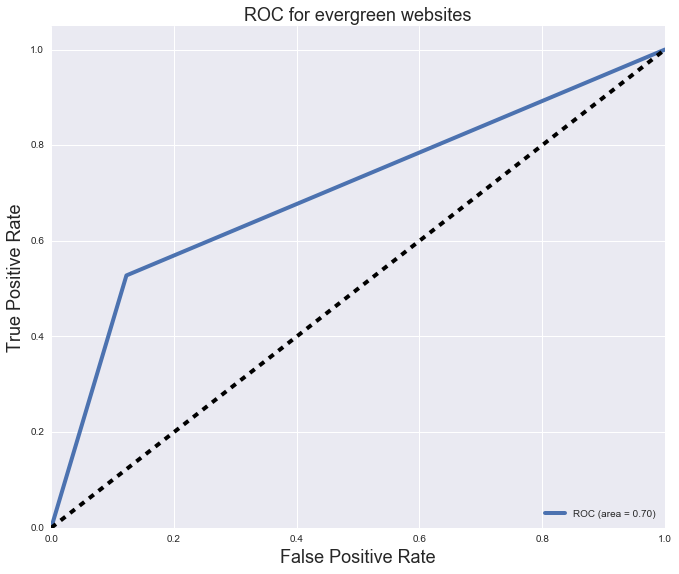

In [40]:
logregL1 = LogisticRegression(C=5, penalty='l1', solver='liblinear')

logL1 = logregL1.fit(X_train, y_train)

y_pred = logregL1.predict(X_test)


print logL1.coef_
print
print "Mean Coefficient = ", logL1.coef_.mean()
plot_roc(y_test, y_pred)

#### Using the input matrix above, fit a logistic regression model using L2 regularization
- Change the `C` parameter - how do the coefficients change? (use `examine_coeffcients`)

[[-0.21542471 -0.54240393  0.90807832  0.45453621  2.47060994 -0.21956234
  -0.11966105  1.8506837   1.6406829   1.68921808  1.99750489  1.58739276
   0.11292403  1.16457799  0.80668889  1.23793221  1.65574719 -0.29323455
   0.34991907 -1.50472371  0.79707365  1.4524702  -0.08388961  0.47306828
   0.53138324  0.07941068  1.20033765  0.2767373   0.25791219  2.17923189
  -0.35397551  1.49239539 -0.79290473 -1.20411789 -0.17515288 -0.51080935
   1.24236507  2.43124397  1.45224391  0.30649481 -0.93747089 -0.55656168
   0.39495743 -0.09712464 -1.68356805 -0.46736229  0.55281173 -1.15670461
   0.50102329 -0.23304273]]

Mean Coefficient =  0.447999233885


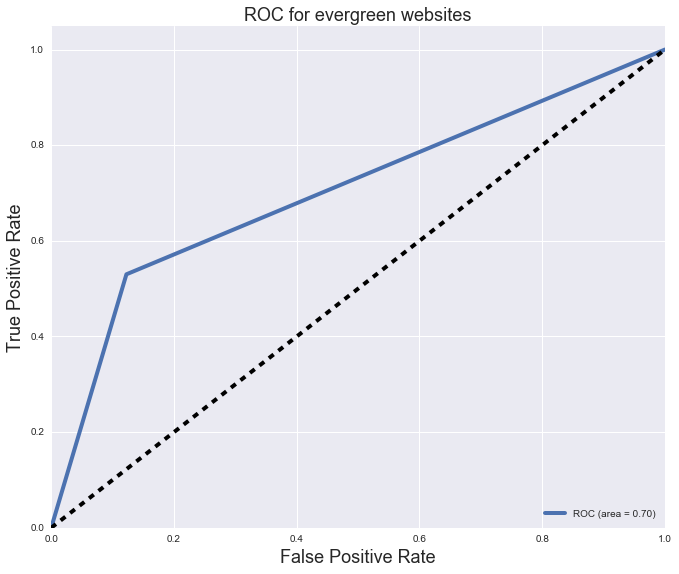

In [41]:
logregL2 = LogisticRegression(C=1, penalty='l2', solver='liblinear')

logL2 = logregL2.fit(X_train, y_train)

y_pred = logregL2.predict(X_test)

print logL2.coef_
print
print "Mean Coefficient = ", logL2.coef_.mean()
plot_roc(y_test, y_pred)

[[-0.21508784 -0.61098303  1.52271881  0.4873311   3.75529888 -0.22183333
  -0.12668199  2.84137093  1.81336564  1.96789344  2.35377525  1.70894496
   0.10370332  1.31465897  0.89654839  1.40844728  1.95066645 -0.34847672
   0.35543076 -1.59832426  0.81385651  1.66119228 -0.08503092  0.52046665
   0.55122142  0.08634558  1.40437141  2.49350047  0.31425389  2.4921879
  -0.38555771  1.59921812 -0.83428652 -1.24403903 -1.01657988 -0.55779373
   1.47278791  2.51436224  1.50809224  0.36194482 -0.97217468 -0.60120401
   0.41047496 -2.25539716 -2.03430997 -0.49925904  0.61888042 -1.19929033
   0.56020305 -0.21871769]]

Mean Coefficient =  0.536769724182


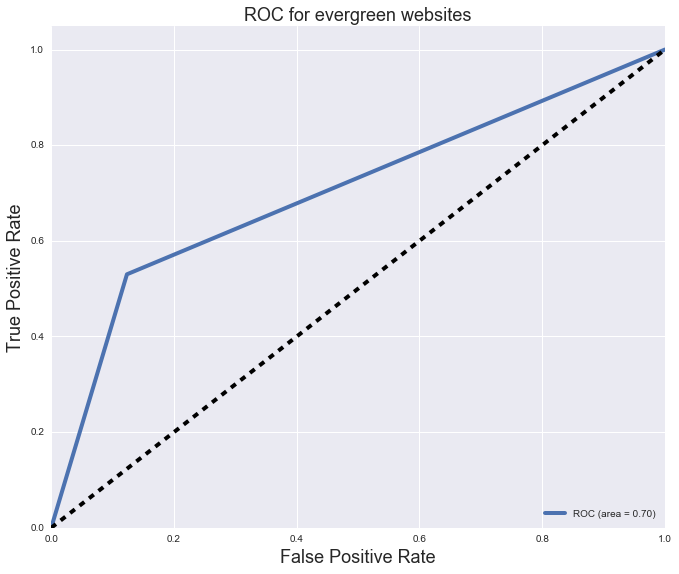

In [44]:
logregL2 = LogisticRegression(C=100, penalty='l2', solver='liblinear')

logL2 = logregL2.fit(X_train, y_train)

y_pred = logregL2.predict(X_test)

print logL2.coef_
print
print "Mean Coefficient = ", logL2.coef_.mean()
plot_roc(y_test, y_pred)

In [12]:
# TODO